In [5]:
import os                      # 导入操作系统模块，用于文件和目录操作
import requests                # 导入HTTP请求库，用于从网络获取数据
import pandas as pd            # 导入数据分析库，用于数据处理和分析
import matplotlib.pyplot as plt # 导入绘图库，用于数据可视化
import math                    # 导入数学函数库，提供数学运算功能
import tiktoken                # 导入OpenAI的分词器，用于文本标记化处理
import torch                   # 导入PyTorch深度学习框架
import torch.nn as nn          # 导入PyTorch神经网络模块，用于构建神经网络层

In [6]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post: 
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [7]:
# 超参数设置
batch_size = 4  # 每个训练步骤的批次大小
context_length = 16  # 每个批次的标记序列长度
d_model = 64  # 标记嵌入向量的维度大小
num_layers = 8  # Transformer块的数量
num_heads = 4  # 多头注意力机制中的头数 # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 学习率，等于0.001
dropout = 0.1 # 丢弃率，防止过拟合
max_iters = 500  # 训练迭代的总次数
eval_interval = 50  # 模型评估的频率
eval_iters = 20  # 评估模型时平均损失的迭代次数
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 如果可用，使用GPU而不是CPU进行训练

TORCH_SEED = 1337  # 设置随机种子
torch.manual_seed(TORCH_SEED)  # 初始化PyTorch的随机数生成器
print("训练位置：", device)

训练位置： cuda


In [8]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [9]:
# 使用TikToken对源文本进行分词
encoding = tiktoken.get_encoding("cl100k_base")  # 获取cl100k_base编码器
tokenized_text = encoding.encode(text)  # 将文本编码为token序列
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)  # 将token序列转换为张量
max_token_value = tokenized_text.max().item()  # 获取词汇表中的最大索引值

print(f"Tokenized text size: {len(tokenized_text)}")  # 打印分词后文本的长度
print(f"The maximum value in the tokenized text is: {max_token_value}")  # 打印词汇表中的最大索引值

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [10]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [11]:
# 划分训练集和验证集
split_idx = int(len(tokenized_text) * 0.9)  # 计算分割点，使用90%的数据作为训练集
train_data = tokenized_text[:split_idx]  # 取前90%的数据作为训练集
val_data = tokenized_text[split_idx:]  # 取剩余10%的数据作为验证集

In [12]:
# 准备训练批次数据
data = train_data  # 使用训练集数据
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))  # 随机生成batch_size个索引，范围在0到数据长度减去上下文长度之间
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])  # 根据索引提取输入序列，每个序列长度为context_length
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])  # 提取目标序列，相当于输入序列向右移动一位（用于下一个token预测）
print("Batch shapes:", x_batch.shape, x_batch.shape)  # 打印批次形状
for i in range(batch_size):  # 遍历每个批次样本
    print(f"\nBatch {i}:")  # 打印批次编号
    print("x:", encoding.decode(x_batch[i].tolist()))  # 解码并打印输入序列的文本
    print("y:", encoding.decode(y_batch[i].tolist()))  # 解码并打印目标序列的文本
    print("-" * 50)  # 打印分隔线

Batch shapes: torch.Size([4, 16]) torch.Size([4, 16])

Batch 0:
x:  the sales process. The ability to effectively communicate the value and benefits of our products
y:  sales process. The ability to effectively communicate the value and benefits of our products or
--------------------------------------------------

Batch 1:
x:  research findings, or industry awards that validate the superiority of your offering. By presenting
y:  findings, or industry awards that validate the superiority of your offering. By presenting these
--------------------------------------------------

Batch 2:
x:  credibility concerns, maintaining a positive attitude, seeking clarification, and embracing objections as learning
y:  concerns, maintaining a positive attitude, seeking clarification, and embracing objections as learning opportunities
--------------------------------------------------

Batch 3:
x:  confirms their understanding but also makes the customer feel heard and understood.
Empathy goes
y:  th

In [13]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [14]:
# 定义词元嵌入查找表
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)  # 创建嵌入层，将词元索引映射为d_model维度的向量
token_embedding_lookup_table.to(device)  # 将嵌入层移动到指定设备（GPU或CPU）
print("Token Embedding Look-up table: ", token_embedding_lookup_table)  # 打印嵌入层的信息

Token Embedding Look-up table:  Embedding(100070, 64)


In [15]:
# 获取输入和目标的嵌入表示
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [批次大小, 上下文长度, 嵌入维度]
y_batch_embedding = token_embedding_lookup_table(y_batch.data) # 将目标序列也转换为嵌入表示

x_batch_embedding.shape, y_batch_embedding.shape # 打印嵌入张量的形状

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [16]:
# 定义位置编码查找表
position_encoding_lookup_table = torch.zeros(context_length, d_model)  # 创建一个形状为[上下文长度, 嵌入维度]的零矩阵
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)  # 生成位置索引向量并扩展维度
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # 计算位置编码的分母项
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)  # 偶数位置使用正弦函数
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)  # 奇数位置使用余弦函数
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1)  # 添加批次维度

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape)  # [4, 16, 64] [批次大小, 上下文长度, 嵌入维度]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())  # 将第一个批次的位置编码转换为数据框并显示

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


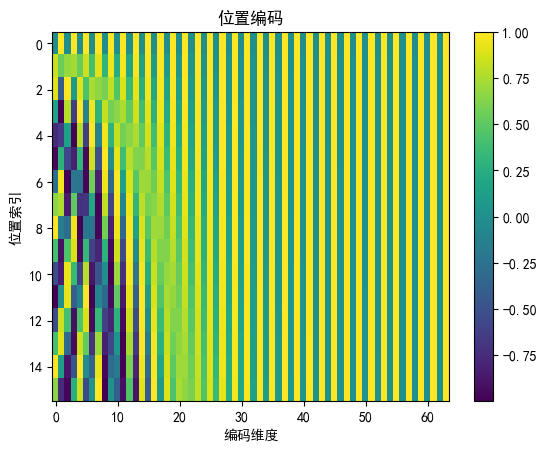

In [17]:
# 设置matplotlib中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 仅用于可视化展示
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")  # 使用热力图显示位置编码矩阵
    plt.title("位置编码")  # 设置图表标题
    plt.xlabel("编码维度")  # 设置x轴标签
    plt.ylabel("位置索引")  # 设置y轴标签
    plt.colorbar()  # 添加颜色条
    plt.show()  # 显示图表

# 获取第一个批次的位置编码并转换为NumPy数组
position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)  # 可视化位置编码矩阵

In [18]:
token_embedding_lookup_table.to(device)  # 将词元嵌入表移动到指定设备（GPU或CPU）
# 将位置编码添加到输入的嵌入向量中
position_encoding_lookup_table = position_encoding_lookup_table.to(device)  # 将位置编码表移动到相同设备
input_embedding_x = x_batch_embedding + position_encoding_lookup_table  # [4, 16, 64] [批次大小, 上下文长度, 嵌入维度]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table  # 为目标序列也添加位置编码
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())  # 将第一个批次的输入嵌入转换为数据框并显示

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


In [19]:
# 准备多头注意力机制所需的查询(Query)、键(Key)、值(Value)向量
X = input_embedding_x  # 将输入嵌入赋值给X
query = key = value = X  # 在自注意力机制中，Q、K、V都来自同一输入 [4, 16, 64] [批次大小, 上下文长度, 嵌入维度]
query.shape  # 打印查询张量的形状

torch.Size([4, 16, 64])

In [20]:
# 定义查询(Query)、键(Key)、值(Value)的权重矩阵
Wq = nn.Linear(d_model, d_model).to(device)  # 查询权重矩阵，将d_model维度映射到d_model维度
Wk = nn.Linear(d_model, d_model).to(device)  # 键权重矩阵，将d_model维度映射到d_model维度
Wv = nn.Linear(d_model, d_model).to(device)  # 值权重矩阵，将d_model维度映射到d_model维度

Q = Wq(query)  # [4, 16, 64] 通过查询权重矩阵变换输入
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  # [4, 16, 4, 16] 重塑张量维度为[批次大小, 序列长度, 注意力头数, 每头维度]

K = Wk(key)  # [4, 16, 64] 通过键权重矩阵变换输入
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  # [4, 16, 4, 16] 重塑张量维度

V = Wv(value)  # [4, 16, 64] 通过值权重矩阵变换输入
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  # [4, 16, 4, 16] 重塑张量维度

# print(torch.round(Q[0] * 100) / 100)  # 打印第一个批次的查询张量（已注释）
#odel.to(device)  # 移动模型到设备（已注释）
qqq = Q.detach().cpu().numpy()  # 将查询张量转移到CPU并转换为NumPy数组
for qs in qqq:  # 遍历每个批次
    for qss in qs:  # 遍历每个序列位置
        print(pd.DataFrame(qss))  # 将每个注意力头的查询向量转换为数据框并打印

print(Q.shape)  # [4, 16, 4, 16] 打印查询张量的形状 [批次大小, 序列长度, 注意力头数, 每头维度]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.843055 -0.550052 -0.127732 -0.844841 -0.819224  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123996 -0.023149  0.141312  0.812356 -1.628145  0.312126
1 -0.350486  0.484634 -0.140094  0.746821  1.481563 -0.266804  0.312059 -0.710153 -0.557109  0.462987 -0.575465  0.824084 -0.910005 -0.060633 -0.851141 -0.696344
2 -0.140998 -0.055692 -0.718412 -0.797249  0.366570  1.513673  0.577341 -0.707246 -0.275017  1.270264 -0.846118 -1.158900  1.652280  0.261800 -0.884520 -0.846511
3 -0.244500  0.759894  0.067822  0.388658 -0.178537  1.044808 -0.276759 -0.887758 -0.158977 -0.619547 -0.298364 -0.604880 -1.250720  0.388842 -1.088378  0.081780
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.614938 -0.657467  0.080

In [21]:
# 转置查询(Q)、键(K)、值(V)张量，从[批次大小, 序列长度, 注意力头数, 每头维度]变为[批次大小, 注意力头数, 序列长度, 每头维度]
# 这样做的原因是为了让每个批次中的注意力头维度作为第二维度，便于后续的并行计算
Q = Q.transpose(1, 2)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 每头维度]
K = K.transpose(1, 2)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 每头维度]
V = V.transpose(1, 2)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 每头维度]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,0.872087,0.805252,0.638937,0.403635,-0.220579,0.074281,0.066307,0.161097,0.776864,-0.015753,0.059171,-0.167397,-0.519080,-0.113654,0.370162
1,1.123528,0.464093,0.514920,-0.184883,0.292599,-0.127226,0.205937,0.207777,0.602376,1.016718,0.158707,0.074483,0.526718,0.460966,0.633765,0.534267
2,1.040623,0.605708,0.119165,-0.133348,-0.169015,-0.146091,0.444743,0.050206,0.774002,0.830742,-0.216136,-0.111672,0.751038,0.496729,0.747770,0.609336
3,0.900046,0.596818,0.359724,0.836026,0.074438,0.652813,1.057635,-0.026944,1.124048,0.971823,-0.467323,-0.247706,0.002623,-0.360195,0.017814,0.965252
4,1.061118,1.158659,0.633724,-0.320907,0.383561,-0.448183,-0.238576,-0.078154,-0.033891,0.852194,0.056047,0.533376,0.968321,0.675573,0.506570,0.651593
5,0.071059,0.273445,0.044782,0.250273,-0.114290,0.121239,0.472958,0.086112,-0.077087,-0.158122,-0.416886,0.212225,0.220158,-0.492304,0.175022,0.505993
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-0.400829,0.203915,0.658944,-0.018270,0.620022,0.600703,0.066074,0.316328,0.332746
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-0.025749,0.031660,0.079259,0.274235,0.095197,-0.625558,-0.000797,0.226548
8,0.529122,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,0.642808,0.532076,0.191681,-0.066689,0.383821,-0.080174,0.330105
9,0.935246,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,0.184269,0.238904,-0.084467,-0.414828,-0.173580,0.431657


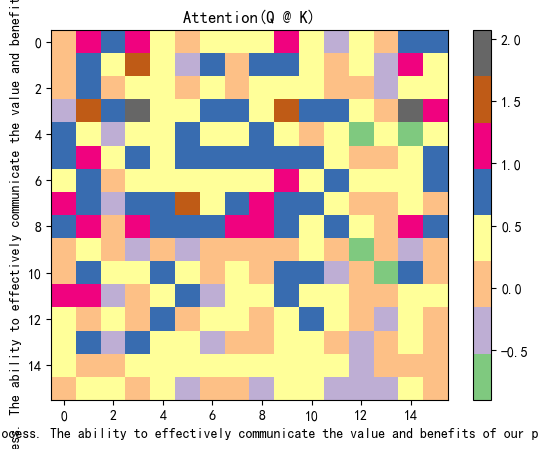

In [22]:
# 计算注意力分数
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 序列长度]

# 可视化注意力分数
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")  # 显示第二个批次的第二个注意力头的注意力矩阵
plt.title("Attention(Q @ K)")  # 设置图表标题：查询和键的注意力得分
plt.xlabel(encoding.decode(x_batch[0].tolist()))  # 设置x轴标签为输入序列的文本
plt.ylabel(encoding.decode(x_batch[0].tolist()))  # 设置y轴标签为输入序列的文本
plt.colorbar()  # 添加颜色条，显示注意力分数的强度
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())  # 将第一个批次的第一个注意力头的分数转换为数据框并显示

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040623,0.605708,0.119165,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900046,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061118,1.158659,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071059,0.273445,0.044782,0.250273,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529122,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935246,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


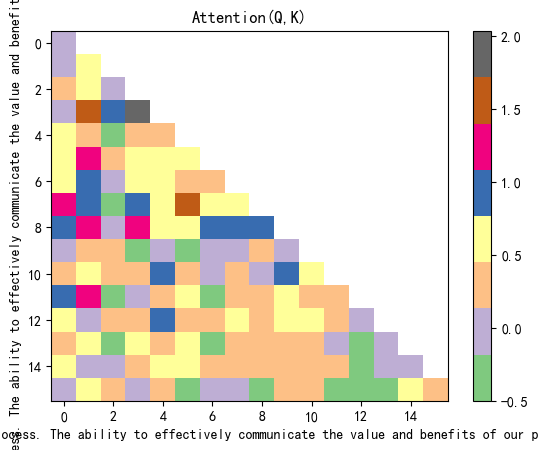

In [23]:
# 对注意力分数应用掩码，实现因果注意力机制
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool().to(device), float('-inf'))  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 序列长度]

# 可视化掩码后的注意力分数
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")  # 显示第二个批次的第二个注意力头的注意力矩阵
plt.title("Attention(Q,K)")  # 设置图表标题：查询和键的注意力得分
plt.xlabel(encoding.decode(x_batch[0].tolist()))  # 设置x轴标签为输入序列的文本
plt.ylabel(encoding.decode(x_batch[0].tolist()))  # 设置y轴标签为输入序列的文本
plt.colorbar()  # 添加颜色条，显示注意力分数的强度
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())  # 将第一个批次的第一个注意力头的分数转换为数据框并显示

In [24]:
# 对注意力分数应用softmax函数，将分数转换为概率分布
attention_score = torch.softmax(attention_score, dim=-1)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 序列长度]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())  # 将第一个批次的第一个注意力头的概率分布转换为数据框并显示

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.659133,0.340867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.488936,0.316498,0.194566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.306845,0.226584,0.178756,0.287816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.284609,0.313769,0.185624,0.071457,0.144541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.159313,0.195051,0.155182,0.190583,0.132360,0.167512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.195804,0.299437,0.138751,0.086341,0.131894,0.048049,0.099724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.100501,0.213640,0.183525,0.068726,0.121962,0.092737,0.131933,0.086976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.176701,0.085500,0.131407,0.107381,0.128974,0.074929,0.052436,0.110609,0.132063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.148425,0.116194,0.097110,0.168735,0.096496,0.046389,0.056222,0.057891,0.069378,0.143160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
# 计算注意力值输出
print(attention_score.shape)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 序列长度]
print(V.shape)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 每头维度]
A = torch.matmul(attention_score, V)  # [4, 4, 16, 16] [批次大小, 注意力头数, 序列长度, 每头维度] 将注意力分数与值矩阵相乘得到加权后的特征表示
print(A.shape)  # 打印输出张量的形状

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [26]:
# 拼接多头注意力的输出
A = A.transpose(1, 2)  # [4, 16, 4, 16] [批次大小, 序列长度, 注意力头数, 每头维度] 调整维度顺序，为拼接做准备
A = A.reshape(batch_size, -1, d_model)  # [4, 16, 64] [批次大小, 序列长度, 模型维度] 将所有注意力头的输出拼接并重塑为原始维度
A.shape  # 打印最终输出张量的形状

torch.Size([4, 16, 64])

In [27]:
# 定义输出权重矩阵，用于将多头注意力的输出映射回原始维度空间
Wo = nn.Linear(d_model, d_model).to(device)  # 创建线性层，输入维度和输出维度都是d_model，并移至指定设备
output = Wo(A)  # [4, 16, 64] [批次大小, 序列长度, 模型维度] 将拼接后的注意力输出通过线性变换
print(output.shape)  # 打印输出张量的形状
pd.DataFrame(output[0].detach().cpu().numpy())  # 将第一个批次的输出转换为数据框并显示

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.064506,0.451883,0.126058,-0.308507,0.429776,-0.321017,0.028085,0.494516,0.014581,-0.300572,...,0.401453,0.703710,-0.791798,0.423244,0.758770,0.434047,-0.165581,-0.510981,-0.012390,0.565687
1,-0.319784,0.270716,-0.050118,-0.361192,0.337563,-0.242993,0.135025,0.104678,0.128337,-0.151392,...,0.253589,0.731760,-0.598175,0.584505,0.856153,0.657069,-0.114799,-0.277092,0.109785,0.568027
2,-0.142772,0.471190,-0.135125,-0.391242,0.240273,-0.426438,0.191585,0.249496,0.114119,-0.148854,...,0.188330,0.707296,-0.513143,0.675920,0.843663,0.519398,0.241321,-0.254675,-0.067157,0.583508
3,-0.112123,0.188070,-0.195295,-0.499538,0.074381,-0.364622,0.126506,0.199517,0.166654,-0.116992,...,0.050666,0.629354,-0.457674,0.544949,0.920907,0.465222,0.169629,-0.187357,0.040276,0.363001
4,-0.020715,0.262572,-0.107539,-0.486144,0.098776,-0.386885,0.132087,0.430532,0.070903,-0.235981,...,0.107817,0.448574,-0.550493,0.264393,0.794209,0.431990,0.282289,-0.231657,-0.063665,0.233252
5,0.008326,0.399232,-0.110658,-0.406787,0.053074,-0.316901,0.138022,0.376357,0.234606,-0.272379,...,0.189062,0.355173,-0.501581,0.171572,0.708473,0.260176,0.336405,-0.285479,-0.020590,0.198434
6,-0.124724,0.291068,-0.078329,-0.373831,0.082521,-0.331801,0.086711,0.314733,0.143774,-0.316907,...,0.183282,0.388413,-0.533431,0.296272,0.681266,0.266746,0.207132,-0.252256,-0.067646,0.238893
7,-0.095166,0.354915,-0.023955,-0.282569,0.061036,-0.429683,0.220804,0.376843,0.187381,-0.233588,...,0.265134,0.267361,-0.426334,0.250288,0.574936,0.035810,0.334888,-0.203362,-0.035591,0.152928
8,-0.214826,0.306409,-0.111830,-0.316602,0.210473,-0.285486,0.234773,0.146622,0.178420,-0.231031,...,0.293020,0.345010,-0.355211,0.474156,0.595328,0.373845,0.198910,-0.092789,0.023336,0.254176
9,-0.150454,0.300733,-0.084071,-0.347423,0.197579,-0.288124,0.055311,0.199533,0.170684,-0.402754,...,0.265382,0.349139,-0.415729,0.308192,0.549358,0.390737,0.178057,-0.118175,-0.048890,0.205317


In [28]:
# 添加残差连接，将原始输入与注意力层的输出相加，帮助缓解深层网络的梯度消失问题
output = output + X  # 将注意力输出与输入张量相加，形状都是 [batch_size, context_length, d_model]

In [29]:
# 添加层归一化，用于稳定深度网络的训练
# 层归一化就像是一个"分数调整器"：
# 假设一个班级40个学生参加数学考试，分数都在20-40分之间。为了更好地评估学生水平：
# 1. 计算平均分（如30分）
# 2. 计算分数的离散程度（标准差）
# 3. 对每个分数进行调整：(原始分数-平均分)/标准差
# 这样，平均水平的学生得分接近0，比平均好的得正分，比平均差的得负分
# 在深度学习中，这种归一化可以让数据分布更稳定，加快学习速度
layer_norm = nn.LayerNorm(d_model).to(device)  # 创建层归一化模块，归一化维度为d_model，并移至指定设备
output_layernorm = layer_norm(output)  # 对注意力输出进行层归一化处理，使特征分布更稳定
pd.DataFrame(output_layernorm[0].detach().cpu().numpy())  # 将第一个批次的归一化后的输出转换为数据框并显示

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.651146,-0.338767,-0.148929,-0.161356,0.311949,-0.170046,-0.216141,0.442356,-0.429932,-1.022561,...,-0.694017,2.361861,-0.168998,1.487987,-0.239246,1.252543,-0.174658,-0.775212,0.943942,0.640914
1,0.363100,-0.849104,1.466489,-0.579043,0.655850,-0.685362,-0.768528,0.966523,-0.191106,1.332588,...,0.397724,2.006668,-0.420414,1.325321,0.936620,0.891607,0.495639,0.094576,0.533806,1.248270
2,-0.074725,0.980796,0.056813,-1.237175,0.314915,0.190817,-0.259984,-0.610276,0.074607,-0.026923,...,-0.874887,1.777116,-2.113541,0.580041,0.736882,2.027560,-1.598542,0.517098,-0.697718,0.426772
3,0.179246,0.030458,-0.569735,-0.104989,-1.366528,-0.495695,0.470146,0.121260,0.130445,0.122128,...,-0.354573,0.313568,-0.797105,-1.502283,1.280802,-0.056257,0.306066,-0.934066,0.964786,1.518714
4,-2.563513,-0.510935,-0.311376,-1.519112,0.359469,-1.862516,-0.512947,-1.038756,1.544263,1.028858,...,0.057547,0.242996,-2.718050,0.473220,0.227851,1.177985,0.263649,-0.435677,-1.025325,0.510210
5,-0.482478,0.590556,0.019868,-0.714125,-0.907016,-1.485950,0.037047,-1.085706,0.550140,-1.750878,...,-0.240454,-0.231969,-1.581884,0.911461,0.742250,0.804169,-1.486456,1.883600,0.423040,1.157790
6,-0.384928,2.368217,-1.233304,-0.274891,-1.163272,-2.937980,0.157442,-0.557870,0.822901,-0.704004,...,-0.007224,0.835525,0.302396,1.134248,0.269431,0.732525,0.927256,0.025089,-0.751859,0.541159
7,-1.358464,1.593172,-1.156507,1.050370,0.534758,-2.573611,-0.686242,-1.448938,1.689372,-0.223139,...,-1.826830,0.893964,-0.599519,2.492607,-0.107149,-0.049579,-1.045270,1.820204,-0.560131,0.557136
8,2.391141,-0.299549,-1.421967,0.484859,-1.719925,-0.908897,-1.402110,-0.834037,-0.264694,-1.519007,...,2.373842,-0.067774,0.604103,1.856966,-0.542771,1.883401,0.416827,0.699533,0.826159,1.874010
9,0.982619,-2.033112,0.143198,-0.202033,-0.640038,-0.626416,-0.631794,-1.310322,0.055473,-2.683001,...,-0.699166,2.025853,0.245274,1.399126,-0.329973,1.236521,0.210675,-0.321495,0.948816,0.377681


In [30]:
# 定义前馈神经网络（Feed Forward Network）
# 想象一个销售数据处理流程：
# 1. 首先扩大数据（ffn_1）：比如把每个销售员的基础信息（姓名、业绩、区域）扩展为更详细的分析数据
# 2. 然后用ReLU激活（只保留正数，负数变0）：相当于筛选出有价值的信息，去掉无用的分析数据
# 3. 最后压缩数据（ffn_2）：把详细的分析结果总结为最终的评估报告
# 4. 随机丢弃一些信息（dropout）：类似随机抽查，避免过度依赖某些特定信息

ffn_1 = nn.Linear(d_model, d_model * 4).to(device)  # 第一个线性层：将64维输入扩展为256维，相当于信息扩充
ffn_2 = nn.Linear(d_model * 4, d_model).to(device)  # 第二个线性层：将256维压缩回64维，相当于信息提炼
relu = nn.ReLU()  # ReLU激活函数：保留正值，负值置0，增加网络的非线性能力

output = ffn_1(output_layernorm)  # 信息扩充：64维 -> 256维
output = relu(output)  # 激活处理：过滤信息，保留有用的特征
output = ffn_2(output)  # 信息压缩：256维 -> 64维
output = torch.dropout(output, p=dropout, train=True)  # 随机丢弃10%的信息，防止过拟合

In [31]:
# Transformer块的最后一次残差连接和层归一化
# 想象一个团队协作的场景：
# 1. 残差连接（output + output_layernorm）：
#    就像项目中保留了原始方案（output_layernorm）的同时，
#    也加入了团队的新想法（output），两者结合可能会产生更好的效果
output = output + output_layernorm  # 将前馈网络的输出与之前的层归一化输出相加

# 2. 最终的层归一化：
#    类似于项目结项前的最后一次评审，确保所有内容都符合标准
#    就像把40个学生的考试成绩（20-40分）调整到合理区间：
#    - 计算平均分（如30分）
#    - 计算分数的离散程度
#    - 对每个分数进行调整：(原始分数-平均分)/标准差
layer_norm = nn.LayerNorm(d_model).to(device)  # 创建最后的层归一化模块
output = layer_norm(output)  # 对残差连接后的结果进行最后的归一化处理
print(output.shape)  # 打印输出张量的形状
pd.DataFrame(output[0].detach().cpu().numpy())  # 将第一个批次的最终输出转换为数据框并显示

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.492721,-0.304139,-0.060955,0.022115,0.655290,-0.145103,0.239940,0.415318,-0.651514,-0.442915,...,-0.631610,2.241465,-0.608588,1.883829,-0.463220,1.103258,-0.149450,-0.657127,0.810417,0.581769
1,0.209421,-0.846087,1.535396,0.021764,0.539496,-0.536314,-0.489034,0.915862,-0.817380,1.444283,...,0.701055,1.947869,-0.854735,1.420465,0.875350,0.792934,0.571957,-0.055002,0.446496,1.240954
2,-0.248044,1.241871,-0.031275,-1.224400,0.436088,0.633428,0.308769,-0.448027,-0.430393,0.281629,...,-0.192376,2.091175,-2.167571,0.645717,0.745682,1.750078,-1.334454,0.479814,-0.619850,-0.068503
3,0.230075,0.353622,-0.626678,0.262564,-1.258798,-0.443695,1.063015,0.103514,-0.387316,0.175475,...,-0.174114,0.564207,-1.017952,-1.072528,1.289631,-0.369401,0.274123,-0.954493,1.071121,0.979907
4,-2.193451,-0.210598,-0.288236,-1.394292,0.658958,-1.585802,-0.337332,-0.829073,0.806231,1.326758,...,0.041772,0.511888,-3.153896,0.685448,0.222869,0.911981,0.803158,-0.432622,-0.804497,0.237993
5,-0.167622,0.768425,0.132469,-0.935052,-0.897041,-1.234121,0.017984,-1.352516,0.356301,-1.702623,...,-0.020989,-0.256903,-1.926932,0.911478,0.864689,0.620858,-1.208101,1.967479,0.476467,0.905482
6,-0.439993,2.589865,-1.132037,-0.273809,-0.965209,-2.636865,0.481789,-0.746952,0.698933,-0.172723,...,0.153432,0.905279,-0.265642,1.105603,0.042010,0.578968,1.506981,-0.242186,-0.740715,0.083579
7,-1.153652,1.408481,-1.212673,1.043569,0.373078,-2.312010,-0.288837,-1.584855,1.514884,0.121352,...,-1.739594,0.783100,-0.921182,2.553599,0.070337,-0.316873,-0.817418,2.102880,-0.582345,0.040309
8,2.175287,-0.294820,-1.209819,0.462317,-1.112015,-0.727813,-1.077558,-0.753115,-0.168593,-1.350666,...,2.408531,-0.144525,0.296743,2.095060,-0.501918,1.812235,0.847187,0.535817,1.006808,1.368955
9,0.824124,-1.747978,0.141354,-0.152774,-0.305169,-0.587864,-0.080551,-1.207446,0.040279,-2.151990,...,-0.698282,2.092984,-0.166505,1.832508,-0.399539,0.932698,0.196257,-0.261398,0.870190,0.347621


In [32]:
# 到这里，我们完成了一个Transformer块的构建
# 想象建造一座高楼：
# 1. 我们刚才完成的是设计一个标准层（Transformer块）
# 2. 实际应用中，我们需要把这个标准层堆叠多次（num_layers=8次）
# 3. 就像一栋8层楼，每层的基本结构是一样的，但处理不同层次的信息
# 4. 底层可能处理简单的语法特征，高层处理更复杂的语义关系
# 但由于这个notebook主要用于演示目的，我们就不做循环堆叠了：
# for _ in range(num_layers):  # 重复8次
#   构建每一层的transformer块

In [33]:
# 应用最后的线性层得到logits（未归一化的预测分数）
# 想象一个翻译官的工作流程：
# 1. 之前的所有层（注意力机制等）就像翻译官在理解外语的过程
# 2. 这最后的线性层就像翻译官最后的决策过程：
#    - 输入是理解后的内容（d_model=64维）
#    - 输出是对每个可能词的打分（max_token_value+1个分数）
#    - 就像翻译官脑中有10万个中文词，要给每个词打分，选最合适的说出来
logits = nn.Linear(d_model, max_token_value+1).to(device)(output)  # 将64维的特征转换为词表大小的分数
pd.DataFrame(logits[0].detach().cpu().numpy())  # 显示第一个序列位置的所有词的预测分数

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.155801,0.180464,0.596153,-0.017949,0.041366,-0.121851,0.794354,-0.068633,-0.318771,-0.646453,...,1.370128,0.093723,-0.379898,-0.025110,-0.327244,-0.936955,0.020995,0.644994,0.959250,0.390118
1,-0.422077,-0.251443,1.352231,0.825049,0.398474,-0.052613,0.504487,-0.144751,-0.214228,-0.637778,...,-0.217320,0.292034,-0.546733,-0.013349,-0.555950,0.222636,-0.470434,0.196748,0.412378,0.382210
2,-0.571919,-0.733112,0.623412,-0.169563,0.538070,0.446169,0.754747,-0.599769,-0.319450,0.165487,...,-0.369003,0.085314,-0.203124,-0.382793,-0.219660,0.042205,0.831860,0.396190,0.412346,0.613144
3,-0.432240,-0.337134,0.573549,0.538490,0.165933,0.382928,0.124495,-0.597629,-0.848559,0.530635,...,0.267792,-0.496862,-0.840303,0.668603,-0.446612,0.310760,0.008038,0.507530,0.962340,0.321170
4,-1.189753,-0.544193,-0.424656,-0.816279,0.283897,0.320089,0.824761,-0.230124,-0.468414,-0.073064,...,1.058757,-0.636552,-0.683172,-0.752391,-0.520178,-0.998149,0.375524,1.235225,0.594753,0.361166
5,-0.893875,-0.991274,-0.740569,-0.362141,-0.586138,0.169634,0.771175,-0.590870,-0.603846,-0.038604,...,0.683018,-0.562341,-1.269034,0.164081,0.088032,0.533080,0.032025,1.200412,0.601406,-0.016751
6,-1.310853,-0.240104,-0.148195,-0.120697,-0.709319,0.929838,0.353181,0.294274,-0.271819,1.008236,...,-0.668948,-1.025035,-0.028996,0.446404,-0.454804,-0.117286,-1.417938,0.065225,0.386163,0.179431
7,-0.354717,-0.936022,0.729367,-0.142910,0.375530,0.004785,-0.046803,0.268830,0.148272,0.107369,...,-0.795772,-0.626380,-0.796488,-0.116123,-1.238130,0.058336,-0.007507,0.242190,-0.497700,-0.541448
8,-0.623057,-0.663126,-0.072224,-0.882645,0.010632,0.395116,0.183503,-0.265350,-0.326854,0.800917,...,-0.088186,-0.354037,-0.438855,1.595173,0.266051,-0.055872,-1.050112,-0.111950,1.034483,0.318923
9,-0.612739,-0.067706,0.305166,-0.167778,-0.586366,-0.342753,0.679522,-0.328543,-0.556313,-0.167517,...,1.371567,0.201304,-0.203404,0.844461,-0.113972,-0.885515,-0.229055,0.618441,1.235993,0.636136


In [34]:
# 获取预测概率分布
# 想象一个投票系统：
# 1. logits就像是每个候选人获得的原始分数（可能有正有负，数值范围不固定）
# 2. softmax就像是一个"标准化器"：
#    - 把所有分数转换为概率（0到1之间）
#    - 所有概率加起来等于1
#    - 分数差距大的会被放大，差距小的会被拉近
# 注意：在实际训练时我们用CrossEntropyLoss，它内部包含了softmax
# 这里用softmax只是为了演示预测结果
probabilities = torch.softmax(logits, dim=-1)  # 将logits转换为概率分布
pd.DataFrame(probabilities[0].detach().cpu().numpy())  # 显示第一个序列位置的所有词的预测概率

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000007,0.000010,0.000015,0.000008,0.000009,0.000007,0.000019,0.000008,0.000006,0.000004,...,0.000033,0.000009,0.000006,0.000008,0.000006,0.000003,0.000009,0.000016,0.000022,0.000012
1,0.000006,0.000007,0.000033,0.000019,0.000013,0.000008,0.000014,0.000007,0.000007,0.000004,...,0.000007,0.000011,0.000005,0.000008,0.000005,0.000011,0.000005,0.000010,0.000013,0.000012
2,0.000005,0.000004,0.000016,0.000007,0.000014,0.000013,0.000018,0.000005,0.000006,0.000010,...,0.000006,0.000009,0.000007,0.000006,0.000007,0.000009,0.000019,0.000013,0.000013,0.000016
3,0.000005,0.000006,0.000015,0.000014,0.000010,0.000012,0.000010,0.000005,0.000004,0.000014,...,0.000011,0.000005,0.000004,0.000016,0.000005,0.000012,0.000009,0.000014,0.000022,0.000012
4,0.000003,0.000005,0.000006,0.000004,0.000011,0.000012,0.000019,0.000007,0.000005,0.000008,...,0.000024,0.000004,0.000004,0.000004,0.000005,0.000003,0.000012,0.000029,0.000015,0.000012
5,0.000003,0.000003,0.000004,0.000006,0.000005,0.000010,0.000018,0.000005,0.000005,0.000008,...,0.000017,0.000005,0.000002,0.000010,0.000009,0.000014,0.000009,0.000028,0.000015,0.000008
6,0.000002,0.000007,0.000007,0.000007,0.000004,0.000021,0.000012,0.000011,0.000006,0.000023,...,0.000004,0.000003,0.000008,0.000013,0.000005,0.000008,0.000002,0.000009,0.000012,0.000010
7,0.000006,0.000003,0.000017,0.000007,0.000012,0.000008,0.000008,0.000011,0.000010,0.000009,...,0.000004,0.000005,0.000004,0.000008,0.000002,0.000009,0.000008,0.000011,0.000005,0.000005
8,0.000005,0.000004,0.000008,0.000003,0.000009,0.000013,0.000010,0.000006,0.000006,0.000019,...,0.000008,0.000006,0.000005,0.000042,0.000011,0.000008,0.000003,0.000008,0.000024,0.000012
9,0.000005,0.000008,0.000011,0.000007,0.000005,0.000006,0.000017,0.000006,0.000005,0.000007,...,0.000033,0.000010,0.000007,0.000020,0.000008,0.000003,0.000007,0.000016,0.000029,0.000016


In [35]:
# 让我们看看原始的输入句子
print("input: " + encoding.decode(x_batch[0].tolist()))
# 让我们看看模型预测的token及其对应的英文单词
# logits[0,0]：获取第一个批次的第一个位置的预测分数
# torch.argmax：找出分数最高的token的索引
predicted_index = torch.argmax(logits[0,0]).item()  # 获取预测概率最高的token索引
print("output: " + encoding.decode([predicted_index]))  # 将预测的token索引解码回原始文本
# 看起来预测的token "tweeted" 并不是原始句子的正确预测token
# 这是因为我们只进行了一次训练循环，模型几乎没有学到任何东西
# 这就是Transformer工作的基本原理

input:  the sales process. The ability to effectively communicate the value and benefits of our products
output:  tweeted
